# Clustering FAN machine

We want to determine the abnormal and normal sound waves based on the features of a machine.
For the pump machine cluster the abnormal and normal sounds based on features such as 
- melspec_std
- melspec_mean
- y_std
- rms_mean

In [1]:
# Import all the necessary libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import rand_score

from sklearn.cluster import KMeans


I will be using the csv file of pump features extracted in the previous project. 
https://github.com/UjjwalKandel2000/Machine-conditions-monitoring
Read the csv file and check the correlatiion with respect to `class` column. Since we have labelled data clustering the data based on the correlation with respect to class can be helpful.


In [2]:
# import the dataset
df = pd.read_csv("dataset/fan_features.csv")
correlation = df.corr()
correlation['class'].sort_values(ascending = False)

class             1.000000
melspec_std       0.249423
melspec_mean      0.216150
y_std             0.158339
rms_mean          0.156008
y_max             0.051917
amp_mean          0.033406
amp_min           0.009500
y_mean            0.004682
flat_max         -0.030815
flat_mean        -0.034966
zcr_max          -0.066178
zcr_min          -0.089588
zcr_mean         -0.096238
y_min            -0.106736
spec_cent_mean   -0.107793
spec_roll_mean   -0.118815
spec_cent_min    -0.123280
spec_roll_min    -0.139238
Name: class, dtype: float64

Based on the above correlation data we can extract those columns and create a model that gives good results. Create another dataframe with the required features of the sound wave that are necessary in labelling the data as `Normal / Abnormal`

In [15]:
df1 = df.filter(['amp_mean','y_max','melspec_std','class'],axis=1)
df1.head()
#'melspec_std','melspec_mean','y_std','rms_mean'

,amp_mean,y_max,melspec_std,class
0,0.015913,0.025436,0.034759,0
1,0.016215,0.023735,0.032697,0
2,0.015449,0.023215,0.037003,0
3,0.015978,0.024671,0.031213,0
4,0.016088,0.026129,0.035059,0


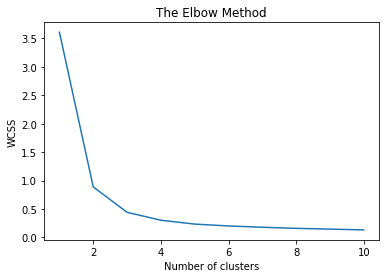

In [16]:
X = df1.iloc[:,:-1].values

Xname = df1.columns[:-1]
X = pd.DataFrame(X,columns=Xname)
# Using the elbow method to find the optimal number of clusters
wcss=[]
for i in range(1,11):
    kMeans = KMeans(n_clusters= i, init= 'k-means++',max_iter=300,n_init=10,random_state=0)
    kMeans.fit(X)
    wcss.append(kMeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

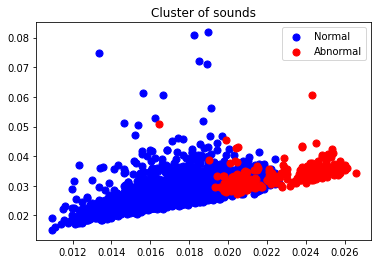

In [17]:
#Applying k-means to the mall dataset
kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=300, n_init=10, random_state=0)
labels = kmeans.fit_predict(X)

#Visualising the clusters
plt.scatter(X.values[labels == 0, 0], X.values[labels == 0, 1], s=50,c='blue',label='Normal')
plt.scatter(X.values[labels == 1, 0], X.values[labels == 1, 1], s=50,c='red',label='Abnormal')
#plt.scatter(X.values[labels == 2, 0], X.values[labels == 2, 1], s=50,c='cyan',label='Transition')
plt.title('Cluster of sounds')

plt.legend()
plt.show()

In [6]:
# checking the count of unique values
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 3364],
       [   1, 2186]])

In [7]:
from sklearn.metrics.cluster import rand_score
rand_score(labels, df1['class'])

0.5157579565508922

For n_clusters = 2 The average silhouette_score is : 0.4537055520187746
For n_clusters = 3 The average silhouette_score is : 0.448821259755321


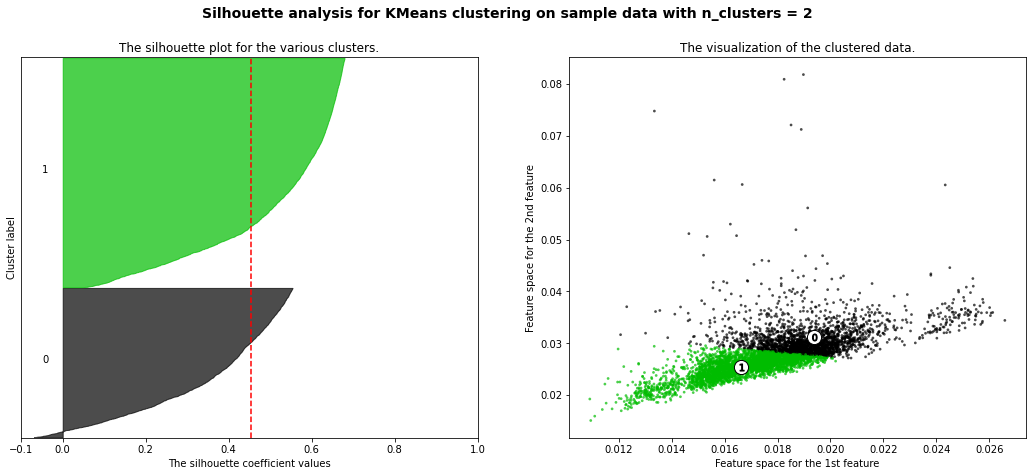

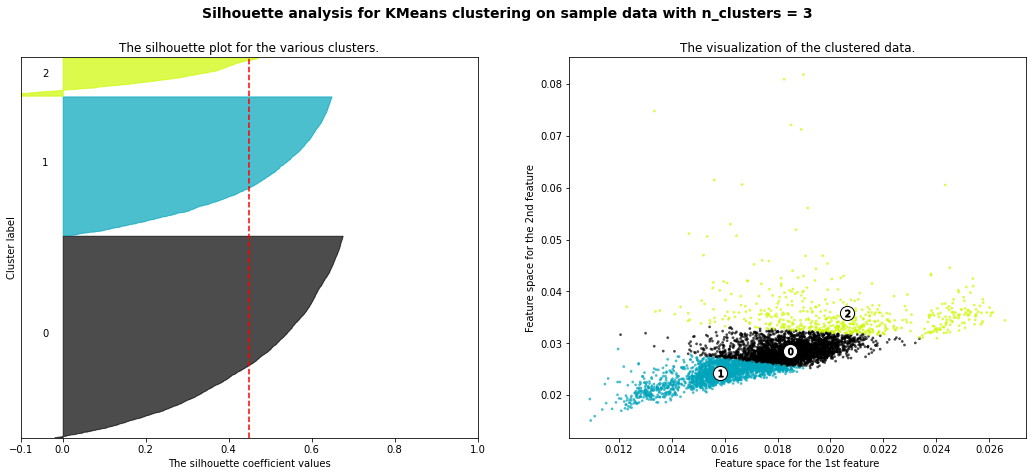

In [8]:
range_n_clusters = [2, 3]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.values[:, 0], X.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [9]:
df1['class'].value_counts()

0    4075
1    1475
Name: class, dtype: int64

In [10]:
(unique, counts) = np.unique(labels, return_counts=True)

frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 3364],
       [   1, 2186]])

## DBSCAN algorithm

Estimated number of clusters: 1
Estimated number of noise points: 296
Homogeneity: 0.033
Completeness: 0.092
V-measure: 0.049
Adjusted Rand Index: 0.094
Adjusted Mutual Information: 0.048
Silhouette Coefficient: 0.585


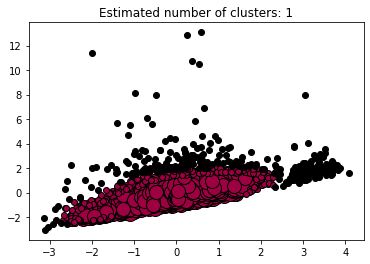

In [11]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_ = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)
n_noise_ = list(labels_).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df['class'], labels_))
print("Completeness: %0.3f" % metrics.completeness_score(df['class'], labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(df['class'], labels_))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(df['class'], labels_))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(df['class'], labels_)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels_))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels_ == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [12]:
(unique, counts) = np.unique(labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[  -1,  296],
       [   0, 5254]])

In [13]:
label1 = pd.DataFrame(labels_,columns=['class'])
label1["class"].replace({-1:1}, inplace=True)

In [14]:
# Calcuate the score of true labels against the predicted labels.
rand_score(label1['class'], df1['class'])

0.6261065462651334